# To visualize small cutouts in Rubin and Euclid together

#### helpers and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.geom as afwGeom

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astroquery.ipac.irsa import Irsa
import fsspec

from scipy.optimize import linear_sum_assignment
from scipy.stats import gaussian_kde
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.coordinates import match_coordinates_sky
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])

def save_bundle(path, **kw):
    np.savez_compressed(path, **{k: v for k, v in kw.items() if v is not None})
    print("saved:", path)


def load_euclid_cutouts(
    ra, dec, size_arcsec,
    bands=("VIS", "Y", "J", "H"),
    collection="euclid_DpdMerBksMosaic",
    radius_arcsec=60,
):
    coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
    tab = Irsa.query_sia(pos=(coord, radius_arcsec * u.arcsec), collection=collection).to_table()
    if "dataproduct_subtype" in tab.colnames:
        tab = tab[tab["dataproduct_subtype"] == "science"]

    out = {b: None for b in bands}
    wcs_out = {}

    for b in bands:
        rows = tab[tab["energy_bandpassname"] == b] if "energy_bandpassname" in tab.colnames else tab
        if len(rows) == 0:
            continue

        url = rows["access_url"][0]

        with fsspec.open(url, "rb") as f:
            with fits.open(f, memmap=False) as hdul:
                wcs0 = WCS(hdul[0].header)
                cut = Cutout2D(hdul[0].data, coord, size_arcsec * u.arcsec, wcs=wcs0)
                out[b] = np.array(cut.data, dtype=np.float32)
                wcs_out[b] = cut.wcs  # cutout-aware WCS

    return out, wcs_out


def load_rubin_cutouts(
    ra, dec, size_arcsec, bands,
    repo="dp1",
    collection="LSSTComCam/DP1",
):
    butler = Butler(repo, collections=collection)

    pixscale = 0.2  # arcsec/pix (fine for this visual/astrometry check)
    n = int(np.round(size_arcsec / pixscale))
    if n % 2 == 1:
        n += 1

    imgs = {b: None for b in bands}
    wcs_local = {}  # <- WCS in CUTOUT pixel coords (0..N-1)

    for b in bands:
        refs = list(butler.query_datasets(
            "deep_coadd",
            where="band.name = band AND patch.region OVERLAPS POINT(ra, dec)",
            bind={"band": b, "ra": ra, "dec": dec},
            with_dimension_records=True,
            order_by=["patch.tract"],
        ))
        if not refs:
            continue

        dataId = refs[0].dataId
        wcs_full = butler.get("deep_coadd.wcs", dataId=dataId)

        sp = geom.SpherePoint(ra, dec, geom.degrees)
        xy_full = geom.PointI(wcs_full.skyToPixel(sp))

        bbox = geom.BoxI(
            xy_full - geom.ExtentI(n, n)//2,
            geom.ExtentI(n, n)
        )

        cut = butler.get("deep_coadd", dataId=dataId, parameters={"bbox": bbox})
        imgs[b] = cut.image.array

        # --- key: make a WCS whose pixel (0,0) corresponds to bbox.min in the full image ---
        x0, y0 = bbox.getMinX(), bbox.getMinY()
        wcs_local[b] = wcs_full.copyAtShiftedPixelOrigin(geom.Extent2D(-x0, -y0))


    return imgs, wcs_local

### Target

In [2]:
ra, dec = 53.16, -28.10 #this is center of ECDFS (Rubin spans ~1degree diameter)
size_arcsec = 500.0
bands_rubin = ["u","g","r","i","z","y"]
bands_euclid = ["VIS","Y","J","H"]


### Plot

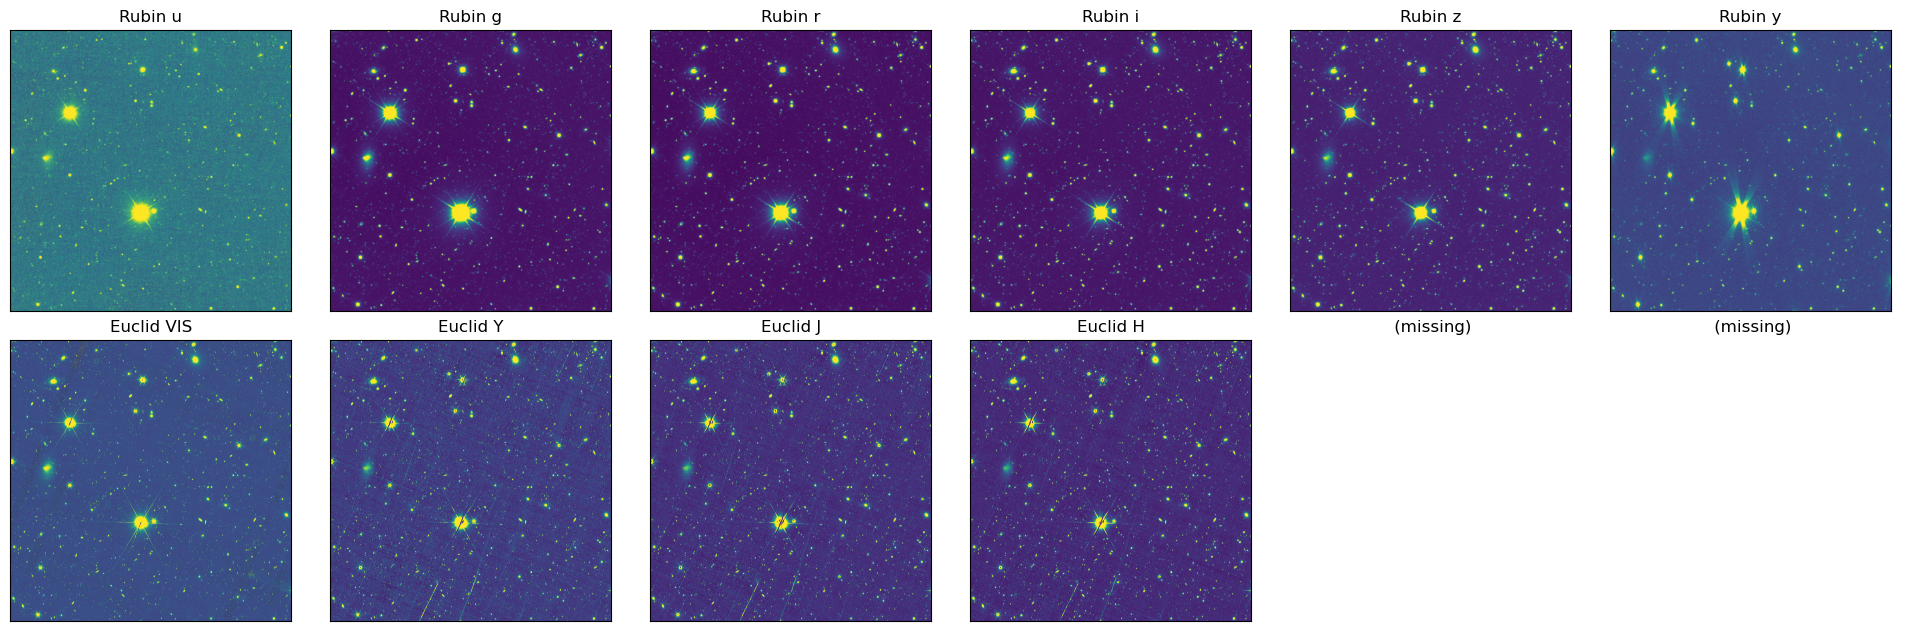

In [3]:
rub, rub_wcs = load_rubin_cutouts(ra, dec, size_arcsec, bands_rubin)
euc, euc_wcs = load_euclid_cutouts(ra, dec, size_arcsec, bands_euclid)

ncol = max(len(bands_rubin), len(bands_euclid))
fig, axes = plt.subplots(2, ncol, figsize=(3.2*ncol, 6.2), constrained_layout=True)

for j in range(ncol):
    ax = axes[0, j]
    b = bands_rubin[j] if j < len(bands_rubin) else ""
    robust_imshow(ax, rub.get(b), f"Rubin {b}" if b else "")

for j in range(ncol):
    ax = axes[1, j]
    b = bands_euclid[j] if j < len(bands_euclid) else ""
    robust_imshow(ax, euc.get(b), f"Euclid {b}" if b else "")

plt.show()


In [4]:
import numpy as np
from scipy.ndimage import maximum_filter, median_filter
from scipy.optimize import linear_sum_assignment
from astropy.coordinates import SkyCoord
import astropy.units as u

# ---------- peak finder (local maxima + robust threshold) ----------
def find_peaks(img, nsigma=3.0, border=10, top=200, local_box=64):
    """
    Detects local maxima above a *local* robust noise threshold.

    local_box : int
        Box size (pixels) for local median/MAD estimation (via median_filter).
        Typical: 32–128 depending on background variation scale.
    """
    data = np.nan_to_num(img, nan=-np.inf)

    # Local robust background + sigma maps
    # (median_filter is robust-ish and fast enough for typical tile sizes)
    m = median_filter(data, size=local_box, mode="nearest")
    mad = median_filter(np.abs(data - m), size=local_box, mode="nearest")
    s = 1.4826 * mad

    thr = m + nsigma * s

    # Local maxima (still on raw data; no PSF assumptions)
    local_max = maximum_filter(data, size=3) == data
    mask = (data > thr) & local_max & np.isfinite(data)

    # Remove border peaks
    if border and border > 0:
        mask[:border, :] = False; mask[-border:, :] = False
        mask[:, :border] = False; mask[:, -border:] = False

    ys, xs = np.where(mask)
    if xs.size == 0:
        return np.array([]), np.array([])

    vals = data[ys, xs]
    order = np.argsort(vals)[::-1]
    if top is not None:
        order = order[:top]

    return xs[order].astype(float), ys[order].astype(float)


# ---------- centroid refinement (replace center-of-mass) ----------
def _parabolic_subpixel_1d(fm1, f0, fp1):
    """
    Subpixel offset of a parabola peak given samples at -1,0,+1.
    Returns dx in [-0.5, 0.5] typically; 0 if curvature is degenerate.
    """
    denom = (fm1 - 2.0 * f0 + fp1)
    if denom == 0 or not np.isfinite(denom):
        return 0.0
    dx = 0.5 * (fm1 - fp1) / denom
    if not np.isfinite(dx):
        return 0.0
    return float(np.clip(dx, -0.75, 0.75))


def refine_centroids(img, xs, ys, r=5):
    """
    Refines peak positions using a robust local-maximum + quadratic (parabolic) subpixel interpolation.

    - Finds the brightest pixel in the cutout after local background subtraction.
    - Uses 1D parabolic interpolation in x and y around that pixel for subpixel offsets.
    """
    outx, outy = [], []
    ny, nx = img.shape

    data = np.nan_to_num(img, nan=-np.inf)

    for x0, y0 in zip(xs, ys):
        ix, iy = int(round(x0)), int(round(y0))
        y1, y2 = max(0, iy - r), min(ny, iy + r + 1)
        x1, x2 = max(0, ix - r), min(nx, ix + r + 1)

        cut = data[y1:y2, x1:x2]
        if cut.size == 0 or not np.isfinite(cut).any():
            outx.append(x0); outy.append(y0)
            continue

        # Local background subtraction (robust) and positivity clamp
        bkg = np.nanmedian(cut[np.isfinite(cut)])
        w = cut - bkg
        w = np.clip(w, 0, None)

        if np.sum(w) <= 0:
            outx.append(x0); outy.append(y0)
            continue

        # Pick the local brightest pixel in the window
        py, px = np.unravel_index(np.argmax(w), w.shape)

        # Need a 3x3 neighborhood for parabolic interpolation
        if py <= 0 or py >= w.shape[0] - 1 or px <= 0 or px >= w.shape[1] - 1:
            outx.append(x1 + px); outy.append(y1 + py)
            continue

        # Parabolic subpixel offsets using the *background-subtracted* weights
        f0 = w[py, px]
        dx = _parabolic_subpixel_1d(w[py, px - 1], f0, w[py, px + 1])
        dy = _parabolic_subpixel_1d(w[py - 1, px], f0, w[py + 1, px])

        outx.append(x1 + px + dx)
        outy.append(y1 + py + dy)

    return np.array(outx), np.array(outy)


# ---------- pixel -> sky  ----------
def pix_to_sky_rubin(wcs, x, y):
    """Rubin-specific pixel to sky conversion."""
    sp = wcs.pixelToSky(geom.Point2D(float(x), float(y)))
    return sp.getRa().asDegrees(), sp.getDec().asDegrees()

def pix_to_sky_astropy(wcs, x, y):
    """Astropy-specific pixel to sky conversion."""
    ra, dec = wcs.all_pix2world([[float(x), float(y)]], 0)[0]
    return float(ra), float(dec)

def skycoords_from_peaks(img, wcs, kind="rubin", nsigma=5,
                         top=None, max_density=10, border=10, refine_r=5,
                         local_box=64):
    """
    Full pipeline: Find peaks -> Refine -> Project to SkyCoords.

    max_density : float
        Maximum sources per square arcminute (used only if top is None).
    local_box : int
        Local background/MAD box (pixels) for detection thresholding.
    """
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=None, local_box=local_box)  # Find ALL

    if xs.size == 0:
        return SkyCoord([], [], unit="deg", frame="icrs")

    # Calculate image area in square arcminutes (best-effort)
    if hasattr(wcs, 'pixel_scale_matrix'):
        pixel_scale = np.sqrt(np.abs(np.linalg.det(wcs.pixel_scale_matrix))) * 3600  # arcsec/pix
    else:
        pixel_scale = 0.2  # fallback
    area_arcsec2 = (img.shape[0] * pixel_scale) * (img.shape[1] * pixel_scale)
    area_arcmin2 = area_arcsec2 / 3600.0

    if top is None:
        top = int(max_density * area_arcmin2)
        print(f"Auto-limiting to {top} brightest sources ({max_density:.1f} per arcmin²)")

    # Sort by brightness BEFORE refinement (using integer indices)
    if xs.size > top:
        xs_int = np.round(xs).astype(int)
        ys_int = np.round(ys).astype(int)
        xs_int = np.clip(xs_int, 0, img.shape[1] - 1)
        ys_int = np.clip(ys_int, 0, img.shape[0] - 1)
        peak_values = img[ys_int, xs_int]  # [y, x]
        sort_idx = np.argsort(peak_values)[-top:]
        xs, ys = xs[sort_idx], ys[sort_idx]

    # NOW refine centroids
    if refine_r and refine_r > 0:
        xs, ys = refine_centroids(img, xs, ys, r=refine_r)

    # Convert to sky coordinates
    if kind == "rubin":
        ra, dec = [], []
        for x, y in zip(xs, ys):
            r, d = pix_to_sky_rubin(wcs, x, y)
            ra.append(r)
            dec.append(d)
    else:
        radec = wcs.all_pix2world(np.column_stack([xs, ys]), 0)
        ra, dec = radec[:, 0], radec[:, 1]

    return SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")


# ---------- matching improvements: affine pre-alignment + residual-space cut ----------
def _sky_to_tangent_arcsec(sky, center):
    """
    Project SkyCoord to a local tangent-plane-ish offset (arcsec) around `center`,
    using spherical offsets (good for small fields).
    Returns Nx2 array [dx, dy] in arcsec.
    """
    dlon, dlat = center.spherical_offsets_to(sky)  # radians
    dx = dlon.to(u.arcsec).value
    dy = dlat.to(u.arcsec).value
    return np.column_stack([dx, dy])

def _fit_affine_iterative(ref_xy, cand_xy, pairs, n_iter=3, clip_sigma=3.0):
    """
    Fit affine transform from ref_xy -> cand_xy using iterative robust clipping.

    Model:
        x' = a x + b y + c
        y' = d x + e y + f
    """
    if pairs.shape[0] < 3:
        return None  # not enough

    A = []
    B = []
    for i_ref, i_cand in pairs:
        x, y = ref_xy[i_ref]
        xp, yp = cand_xy[i_cand]
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        B.append(xp)
        B.append(yp)
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float)

    keep = np.ones(len(B), dtype=bool)

    params = None
    for _ in range(n_iter):
        Ak = A[keep]
        Bk = B[keep]
        if Ak.shape[0] < 6:
            break
        params, *_ = np.linalg.lstsq(Ak, Bk, rcond=None)

        # compute residuals for each pair (in arcsec)
        a, b, c, d, e, f = params
        x = ref_xy[pairs[:, 0], 0]
        y = ref_xy[pairs[:, 0], 1]
        xp = cand_xy[pairs[:, 1], 0]
        yp = cand_xy[pairs[:, 1], 1]
        xhat = a * x + b * y + c
        yhat = d * x + e * y + f
        res = np.sqrt((xhat - xp) ** 2 + (yhat - yp) ** 2)

        med = np.median(res)
        sig = 1.4826 * np.median(np.abs(res - med))
        if sig <= 0 or not np.isfinite(sig):
            break

        good_pairs = (res < med + clip_sigma * sig)
        keep_pairs = np.repeat(good_pairs, 2)  # because A/B are doubled rows
        if keep_pairs.sum() == keep.sum():
            break
        keep = keep_pairs

    return params

def hungarian_match(ref_sky, cand_sky, max_sep_arcsec=0.4):
    """
    Matching with:
      (1) affine pre-alignment in tangent plane (handles rotation/scale/shear-ish)
      (2) Hungarian assignment on residual distances
      (3) robust residual-space coherence cut
    """
    if len(ref_sky) == 0 or len(cand_sky) == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([])

    # Tangent-plane coordinates (arcsec) around ref median center
    center = SkyCoord(np.median(ref_sky.ra), np.median(ref_sky.dec), frame="icrs")
    ref_xy = _sky_to_tangent_arcsec(ref_sky, center)
    cand_xy = _sky_to_tangent_arcsec(cand_sky, center)

    # ---- 1) Build rough pair set with a *looser* radius, then fit affine
    loose = max_sep_arcsec * 5.0
    idx_ref, idx_cand, sep2d, _ = ref_sky.search_around_sky(cand_sky, loose * u.arcsec)
    # NOTE: search_around_sky returns (idx_self, idx_other) in that order:
    # Here: cand_sky.search_around_sky(ref_sky, ...) would swap.
    # With ref_sky.search_around_sky(cand_sky, ...):
    # idx_ref are indices into ref_sky, idx_cand into cand_sky.
    if len(idx_ref) >= 6:
        pairs = np.column_stack([idx_ref, idx_cand])
        params = _fit_affine_iterative(ref_xy, cand_xy, pairs, n_iter=3, clip_sigma=3.0)
    else:
        params = None

    # Apply affine transform to ref points (or identity if unavailable)
    if params is None:
        ref_xy_w = ref_xy
    else:
        a, b, c, d, e, f = params
        x = ref_xy[:, 0]; y = ref_xy[:, 1]
        ref_xy_w = np.column_stack([a * x + b * y + c, d * x + e * y + f])

    # ---- 2) Cost matrix in residual space (arcsec)
    dx = ref_xy_w[:, None, 0] - cand_xy[None, :, 0]
    dy = ref_xy_w[:, None, 1] - cand_xy[None, :, 1]
    dist = np.sqrt(dx * dx + dy * dy)

    cost = np.where(dist <= max_sep_arcsec, dist, 1e6)
    r, c = linear_sum_assignment(cost)

    # Keep feasible matches
    ok = cost[r, c] < 1e5
    r, c = r[ok], c[ok]

    if len(r) < 5:
        # return true on-sky separations for those matches
        seps = ref_sky[r].separation(cand_sky[c]).to(u.arcsec).value
        return r, c, seps

    # ---- 3) Robust residual-space coherence cut (after affine)
    resid = dist[r, c]  # arcsec residuals in tangent plane
    med = np.median(resid)
    sig = 1.4826 * np.median(np.abs(resid - med))
    if not np.isfinite(sig) or sig <= 0:
        seps = ref_sky[r].separation(cand_sky[c]).to(u.arcsec).value
        return r, c, seps

    coherent = resid < (med + 3.0 * sig)

    r2, c2 = r[coherent], c[coherent]
    seps = ref_sky[r2].separation(cand_sky[c2]).to(u.arcsec).value
    return r2, c2, seps


In [ ]:
import time

t0 = time.time()
xs, ys = find_peaks(img, nsigma=5, border=10, top=None, local_box=64)
t1 = time.time()
xs2, ys2 = refine_centroids(img, xs[:500], ys[:500], r=5)  # sample
t2 = time.time()

print("find_peaks:", t1 - t0, "sec,", len(xs), "peaks")
print("refine_centroids (500):", t2 - t1, "sec")


In [ ]:
# Diagnostic: See how many sources are detected before limiting
def count_detections(img, nsigma=5, border=10, local_box=64):
    xs, ys = find_peaks(img, nsigma=nsigma, border=border, top=None, local_box=local_box)
    return len(xs)

# Rubin bands
for b in ["u", "g", "r", "i", "z"]:
    n = count_detections(rub[b], nsigma=5, border=10, local_box=64)
    print(f"Rubin {b}: {n} total detections above 5σ (local MAD)")

# Euclid bands
for b in ["VIS", "Y", "J", "H"]:
    n = count_detections(euc[b], nsigma=5, border=10, local_box=64)
    print(f"Euclid {b}: {n} total detections above 5σ (local MAD)")


In [ ]:
# Use band-specific limits based on actual depths
band_configs = {
    # VIS is deep - can use many
    'VIS': {'top': 10000, 'nsigma': 5},
    
    # Rubin: Match to actual detection counts
    'u': {'top': 2000, 'nsigma': 6},   # Shallow, be more conservative with nsigma
    'g': {'top': 6000, 'nsigma': 5},   
    'r': {'top': 6000, 'nsigma': 5},
    'i': {'top': 6000, 'nsigma': 5},
    'z': {'top': 5000, 'nsigma': 5},
    'y': {'top': 4000, 'nsigma': 6},   # y-band struggles, increase threshold
    
    # Euclid IR: Good depth
    'Y': {'top': 8000, 'nsigma': 5},
    'J': {'top': 8000, 'nsigma': 5},
    'H': {'top': 8000, 'nsigma': 5},
}

# Reference catalog
ref = skycoords_from_peaks(
    euc["VIS"], euc_wcs["VIS"], 
    kind="astropy",
    **band_configs['VIS'],
    border=20, 
    refine_r=5
)

print(f"Reference: {len(ref)} sources from Euclid VIS\n")

# Rubin bands
for b in ["u", "g", "r", "i", "z", "y"]:
    cand = skycoords_from_peaks(
        rub[b], rub_wcs[b],
        kind="rubin",
        **band_configs[b],
        border=20, 
        refine_r=5
    )
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=0.1)
    median_mas = np.median(sep) * 1000 if len(sep) else np.nan
    print(f"Rubin {b}: matches={len(sep):4d}  median={median_mas:6.1f} mas")

print()

# Euclid IR bands
for b in ["Y", "J", "H"]:
    cand = skycoords_from_peaks(
        euc[b], euc_wcs[b],
        kind="astropy",
        **band_configs[b],
        border=20, 
        refine_r=5
    )
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=0.1)
    median_mas = np.median(sep) * 1000 if len(sep) else np.nan
    print(f"Euclid {b}: matches={len(sep):4d}  median={median_mas:6.1f} mas")

Reference: 10000 sources from Euclid VIS

Rubin u: matches= 213  median=  50.6 mas
Rubin g: matches= 932  median=  32.3 mas


In [28]:
# Add this diagnostic version to see what's happening:

def plot_all_bands_astrometry_diagnostic(ref, catalogs, ref_name="Euclid VIS", 
                                        view_limit=100, remove_systematic_offset=False):
    """
    Diagnostic version with scatter points shown
    """
    
    band_colors = {
        'u': '#0B1F3A', 'g': '#143A6F', 'r': '#1F5FA3', 'i': '#4B8FD1', 'z': '#8FC6FF', "y":'#00FFFF',
        'Y': '#B7B8FF', 'J': '#E3A6D9', 'H': '#F2A37B', 
    }
    band_order = ['u', 'g', 'r', 'i', 'z','y', 'Y', 'J', 'H']
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    ax.set_facecolor('#6D6D6D') 
    ax.set_xlim(-view_limit, view_limit)
    ax.set_ylim(-view_limit, view_limit)
    
    band_handles = []
    
    print(f"\n{'Band':<6} {'N_matches':<10} {'Median offset':<15} {'RMS':<10} {'Spread (std)':<15}")
    print("-" * 70)
    
    for band_name in band_order:
        if band_name not in catalogs:
            continue
            
        cand_coords, ri, ci = catalogs[band_name]
        if len(ri) == 0:
            continue
            
        matched_ref = ref[ri]
        matched_cand = cand_coords[ci]
        
        # Raw shifts
        dra_raw = (matched_cand.ra.deg - matched_ref.ra.deg) * 3600 * \
                  np.cos(np.radians(matched_ref.dec.deg)) * 1000
        ddec_raw = (matched_cand.dec.deg - matched_ref.dec.deg) * 3600 * 1000
        
        med_ra = np.median(dra_raw)
        med_dec = np.median(ddec_raw)
        median_offset = np.sqrt(med_ra**2 + med_dec**2)
        
        if remove_systematic_offset:
            dra = dra_raw - med_ra
            ddec = ddec_raw - med_dec
        else:
            dra = dra_raw
            ddec = ddec_raw
        
        rms = np.sqrt(np.mean(dra**2 + ddec**2))
        std_ra = np.std(dra)
        std_dec = np.std(ddec)
        
        print(f"{band_name:<6} {len(ri):<10} {median_offset:>13.2f}   {rms:>8.2f}   RA={std_ra:.2f} Dec={std_dec:.2f}")
        
        color = band_colors.get(band_name, '#FFFFFF')
        
        # SHOW THE ACTUAL POINTS
        ax.scatter(dra, ddec, c=color, s=10, alpha=0.3, edgecolors='none')
        
        # Create contours with moderate smoothing
        if len(dra) > 10:
            n_bins = 30  # Moderate number
            
            H, xedges, yedges = np.histogram2d(dra, ddec, bins=n_bins)
            
            # Moderate smoothing
            H_smooth = gaussian_filter(H.T, sigma=1.5)
            
            if H_smooth.max() > 0:
                # Use 68th percentile (true 1-sigma)
                level = np.percentile(H_smooth[H_smooth > 0], 68)
                
                X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, 
                                  (yedges[:-1] + yedges[1:]) / 2)
                
                ax.contour(X, Y, H_smooth, levels=[level], 
                          colors=color, linewidths=2.5, alpha=1.0)
        
        band_handles.append(mpatches.Patch(color=color, label=f"{band_name} (n={len(ri)})"))
    
    # Styling
    ax.grid(True, alpha=0.2, color='white', linewidth=0.5)
    ax.axhline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)
    ax.axvline(0, color='white', linestyle='--', alpha=0.5, linewidth=1)
    
    for r in [10, 50]:
        circle = Circle((0, 0), r, fill=False, edgecolor='white', 
                       linestyle=':', alpha=0.5, linewidth=1)
        ax.add_patch(circle)
    
    ax.set_xlabel(f'Astrometric shift vs {ref_name} (R.A.) [mas]', fontsize=13)
    ax.set_ylabel(f'Astrometric shift vs {ref_name} (Declination) [mas]', fontsize=13)
    
    ax.legend(handles=band_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
              fontsize=11, framealpha=0.95, facecolor='white')
    
    ax.text(0.02, 0.98, "1σ contours + scatter\n(all matched points)", 
            transform=ax.transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    plt.tight_layout()
    return fig, ax

In [33]:
ref = skycoords_from_peaks(euc["VIS"], euc_wcs["VIS"], kind="astropy", nsigma=5, top=5000)

catalogs = {}
max_sep = 0.1  # 100 mas

for b in ["u", "g", "r", "i", "z","y"]:
    cand = skycoords_from_peaks(rub[b], rub_wcs[b],kind="rubin", nsigma=5, top=5000)
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=max_sep)
    catalogs[b] = (cand, ri, ci)

for b in ["Y", "J", "H"]:
    cand = skycoords_from_peaks(euc[b], euc_wcs[b], kind="astropy", nsigma=5, top=5000)
    ri, ci, sep = hungarian_match(ref, cand, max_sep_arcsec=max_sep)
    catalogs[b] = (cand, ri, ci)



Band   N_matches  Median offset   RMS        Spread (std)   
----------------------------------------------------------------------
u      209                 6.69      53.21   RA=32.64 Dec=41.54
g      725                 7.50      39.37   RA=27.51 Dec=27.11
r      822                 6.36      29.98   RA=20.53 Dec=20.96
i      889                 5.31      29.74   RA=19.89 Dec=21.41
z      790                 8.86      31.60   RA=19.75 Dec=23.29
y      433                 8.22      45.47   RA=29.88 Dec=33.15
Y      1361               16.37      44.14   RA=27.36 Dec=29.85
J      1265               10.88      37.85   RA=25.11 Dec=26.18
H      1227               10.35      37.25   RA=25.07 Dec=25.49


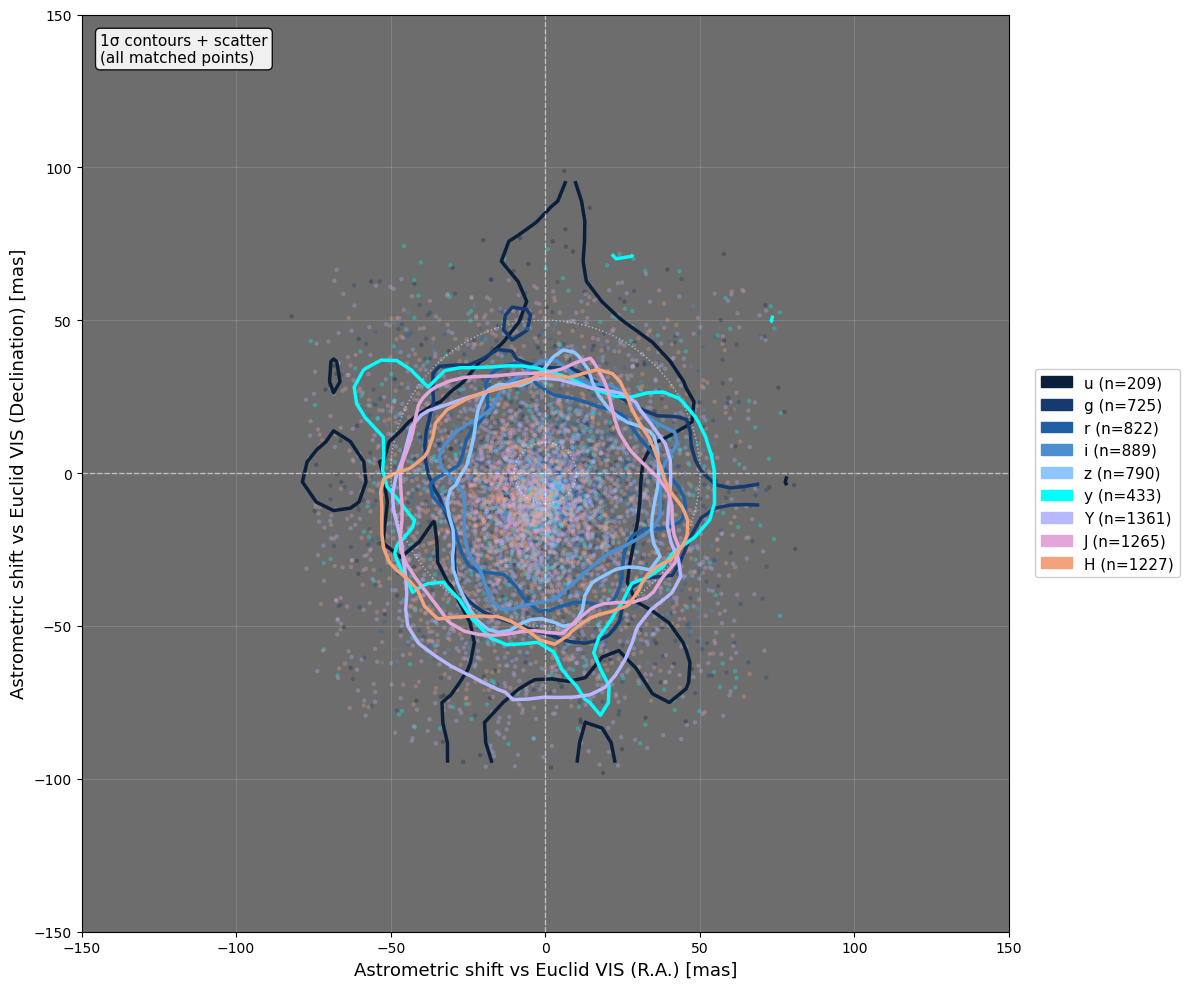

In [35]:
fig, ax = plot_all_bands_astrometry_diagnostic(ref, catalogs, view_limit=150, remove_systematic_offset=False)
plt.savefig('astrometry_all_bands_both.png', dpi=200, bbox_inches='tight')
plt.show()

In [9]:
def plot_spatial_offsets_vs_vis_cellsize(pos_series, which="Rubin i",
                                        cell_arcsec=20.0, min_count=10,
                                        stat="median", vmax=None):
    # pick series
    for name, ra, dec, dra, ddec in pos_series:
        if name == which:
            ra = np.asarray(ra); dec = np.asarray(dec)
            dra = np.asarray(dra); ddec = np.asarray(ddec)
            break
    else:
        raise ValueError(f"{which} not found in pos_series")

    # convert to a local tangent-ish plane in arcsec for binning
    ra0 = np.median(ra)
    dec0 = np.median(dec)
    x = (ra - ra0) * np.cos(np.deg2rad(dec0)) * 3600.0  # arcsec
    y = (dec - dec0) * 3600.0                           # arcsec

    # offsets to summarize
    r = np.hypot(dra, ddec)  # arcsec magnitude

    # define grid edges at requested cell size
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xb = np.arange(np.floor(xmin/cell_arcsec)*cell_arcsec,
                   np.ceil (xmax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)
    yb = np.arange(np.floor(ymin/cell_arcsec)*cell_arcsec,
                   np.ceil (ymax/cell_arcsec)*cell_arcsec + cell_arcsec,
                   cell_arcsec)

    nx, ny = len(xb)-1, len(yb)-1
    grid = np.full((ny, nx), np.nan, dtype=float)
    cnt  = np.zeros((ny, nx), dtype=int)

    # bin
    ix = np.clip(np.digitize(x, xb) - 1, 0, nx-1)
    iy = np.clip(np.digitize(y, yb) - 1, 0, ny-1)

    for j in range(ny):
        for i in range(nx):
            m = (ix == i) & (iy == j)
            n = int(m.sum())
            cnt[j, i] = n
            if n < min_count:
                continue
            vals = r[m]
            if stat == "median":
                grid[j, i] = np.median(vals)
            elif stat == "p68":
                grid[j, i] = np.quantile(vals, 0.68)
            else:
                raise ValueError("stat must be 'median' or 'p68'")

    # plot (axes in RA/Dec-ish arcsec from center)
    fig, ax = plt.subplots(figsize=(7.2, 6.2))
    im = ax.imshow(
        grid, origin="lower",
        extent=[xb[0], xb[-1], yb[0], yb[-1]],
        vmin=0, vmax=vmax, aspect="equal"
    )
    cb = plt.colorbar(im, ax=ax)
    cb.set_label(f"{stat} |Δ| (arcsec)")

    # annotate counts
    xc = 0.5*(xb[:-1] + xb[1:])
    yc = 0.5*(yb[:-1] + yb[1:])
    for j in range(ny):
        for i in range(nx):
            if cnt[j, i] >= min_count:
                ax.text(xc[i], yc[j], f"{cnt[j,i]}", ha="center", va="center", fontsize=9)

    ax.axhline(0, color="0.3", lw=1)
    ax.axvline(0, color="0.3", lw=1)
    ax.set_xlabel("ΔRA·cos(dec) (arcsec) from cutout center")
    ax.set_ylabel("ΔDec (arcsec) from cutout center")
    ax.set_title(f"Spatial offsets vs Euclid VIS: {which}  (cell={cell_arcsec:.0f}\")")
    plt.show()

plot_spatial_offsets_vs_vis_cellsize(pos_series, which="Rubin i",
                                     cell_arcsec=100, min_count=1, stat="median",
                                     vmax=0.1)



NameError: name 'pos_series' is not defined